In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
import os
import json

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
import statsmodels.api as sm

from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.preprocessing import StandardScaler, MaxAbsScaler
import sklearn.cluster as sklc  # For clustering
import sklearn.metrics as sklm  # For the silhouette score

import scipy.stats as stats

In [15]:
polygon = gpd.read_file(r'./LAD/Local_Authority_Districts_(May_2021)_UK_BFE/LAD_MAY_2021_UK_BFE_V2.shp')
england = pd.read_excel('England_class.xlsx')
england_poly = pd.merge(england, polygon, left_on='LAD', right_on='LAD21CD', how='left')
england_poly_geo = gpd.GeoDataFrame(england_poly, crs="EPSG:27700", geometry=england_poly['geometry'])

In [2]:
df =  pd.read_csv('./OUTPUT/Data_Input.csv')

In [3]:
df['Greenspace_Density'] = 1 / df['Greenspace_Density']

In [4]:
analysis = df.loc[:308][['LAD','NDVI','Human_Population_Density','GHG',
                         'Built_Environment_Density','Road_Density',
                         'Greenspace_Density','Habitat_Density', 'Cropland_Density',
                         'NOx_Concentration','O3_Concentration',
                         'Nitrate_Concentration','Orthophosphate_Concentration']]

# Min-max 

In [6]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(analysis[['NDVI','Human_Population_Density','GHG',
                         'Built_Environment_Density','Road_Density',
                         'Greenspace_Density','Habitat_Density', 'Cropland_Density',
                         'NOx_Concentration','O3_Concentration',
                         'Nitrate_Concentration','Orthophosphate_Concentration']])
minmax_norm = scaler.transform(analysis[['NDVI','Human_Population_Density','GHG',
                         'Built_Environment_Density','Road_Density',
                         'Greenspace_Density','Habitat_Density', 'Cropland_Density',
                         'NOx_Concentration','O3_Concentration',
                         'Nitrate_Concentration','Orthophosphate_Concentration']])

In [7]:
a = pd.DataFrame(minmax_norm)

In [8]:
a['NDVI'] = a[0]
a['Human_Population_Density'] = a[1]
a['GHG'] = a[2]
a['Built_Environment_Density'] = a[3]
a['Road_Density'] = a[4]
a['Greenspace_Density'] = a[5]
a['Habitat_Density'] = a[6]
a['Cropland_Density'] = a[7]
a['NOx_Concentration'] = a[8]
a['O3_Concentration'] = a[9]
a['Nitrate_Concentration'] = a[10]
a['Orthophosphate_Concentration'] = a[11]

In [9]:
minmax_norm = a[['NDVI','Human_Population_Density','GHG',
                         'Built_Environment_Density','Road_Density',
                         'Greenspace_Density','Habitat_Density', 'Cropland_Density',
                         'NOx_Concentration','O3_Concentration',
                         'Nitrate_Concentration','Orthophosphate_Concentration']]
minmax_norm

,NDVI,Human_Population_Density,GHG,Built_Environment_Density,Road_Density,Greenspace_Density,Habitat_Density,Cropland_Density,NOx_Concentration,O3_Concentration,Nitrate_Concentration,Orthophosphate_Concentration
0,0.725195,0.061204,0.033518,0.199246,0.192485,0.010579,0.255219,0.033677,0.110385,0.509008,0.097329,0.046675
1,0.589634,0.168805,0.064412,0.432989,0.536138,0.003864,0.177775,0.053388,0.165388,0.448872,0.097329,0.046675
2,0.785207,0.033889,0.035601,0.138293,0.102758,0.045954,0.123947,0.013345,0.289311,0.509008,0.085486,0.005657
3,0.740162,0.059544,0.064955,0.216845,0.197746,0.027603,0.103544,0.015744,0.190310,0.509008,0.222257,0.202513
4,0.795945,0.033187,0.013736,0.103835,0.110923,0.024536,0.081472,0.016018,0.289311,0.509008,0.207272,0.117075
...,...,...,...,...,...,...,...,...,...,...,...,...
304,0.607316,0.303402,0.070846,0.528286,0.534723,0.005348,0.297521,0.031051,0.301679,0.373896,0.306019,0.014354
305,0.234316,1.000000,0.269044,0.669692,0.738976,0.017548,0.199524,0.145201,0.494858,0.383956,0.287010,0.176234
306,0.488581,0.456124,0.097421,0.546986,0.597288,0.008073,0.280168,0.019315,0.301679,0.373896,0.492239,0.183929
307,0.483977,0.608399,0.129699,0.613180,0.678159,0.005196,0.216674,0.015331,0.535636,0.383956,0.910951,0.223823


In [10]:
dataframe = minmax_norm.copy()

# Five domains

In [11]:
climate = dataframe.loc[:,['GHG']]
landuse = dataframe.loc[:,['Built_Environment_Density','Greenspace_Density','Habitat_Density', 'Cropland_Density']]
pollution = dataframe.loc[:,['NOx_Concentration','O3_Concentration',
                         'Nitrate_Concentration','Orthophosphate_Concentration','Built_Environment_Density','Road_Density']]
overexploitation = dataframe.loc[:,['Human_Population_Density']]
alien = dataframe.loc[:,['Road_Density']]

In [12]:
dataframe['landuse'] = dataframe['Built_Environment_Density']/4 + dataframe['Cropland_Density']/4 + dataframe['Greenspace_Density']/4 + dataframe['Habitat_Density']/4
dataframe['climate'] = dataframe['GHG']
dataframe['overexplo'] = dataframe['Human_Population_Density']
dataframe['alien'] = dataframe['Road_Density']

dataframe['air_pollution'] = dataframe['NOx_Concentration']/2 + dataframe['O3_Concentration']/2
dataframe['water_pollution'] = dataframe['Nitrate_Concentration']/2 + dataframe['Orthophosphate_Concentration']/2
dataframe['noise_pollution'] = dataframe['Road_Density']
dataframe['light_pollution'] = dataframe['Built_Environment_Density']/2 + dataframe['Road_Density']/2

In [13]:
dataframe['pollution'] = dataframe['air_pollution']*0.25 + dataframe['water_pollution']*0.25 + dataframe['noise_pollution']*0.25 + dataframe['light_pollution']*0.25

In [14]:
dataframe['Composite_Indicator'] = (dataframe['landuse']*0.2 + 
                                    dataframe['climate']*0.2 + 
                                    dataframe['overexplo']*0.2 + 
                                    dataframe['pollution']*0.2 + 
                                    dataframe['alien']*0.2)

In [16]:
minmax = pd.concat([england_poly_geo, dataframe], axis = 1)
LAD = minmax.reindex(england_poly_geo.index)

In [17]:
CI = LAD[['LAD','Composite_Indicator']]

In [18]:
LAD['Composite_Indicator_rank'] = LAD['Composite_Indicator'].rank(ascending = False, method='first')

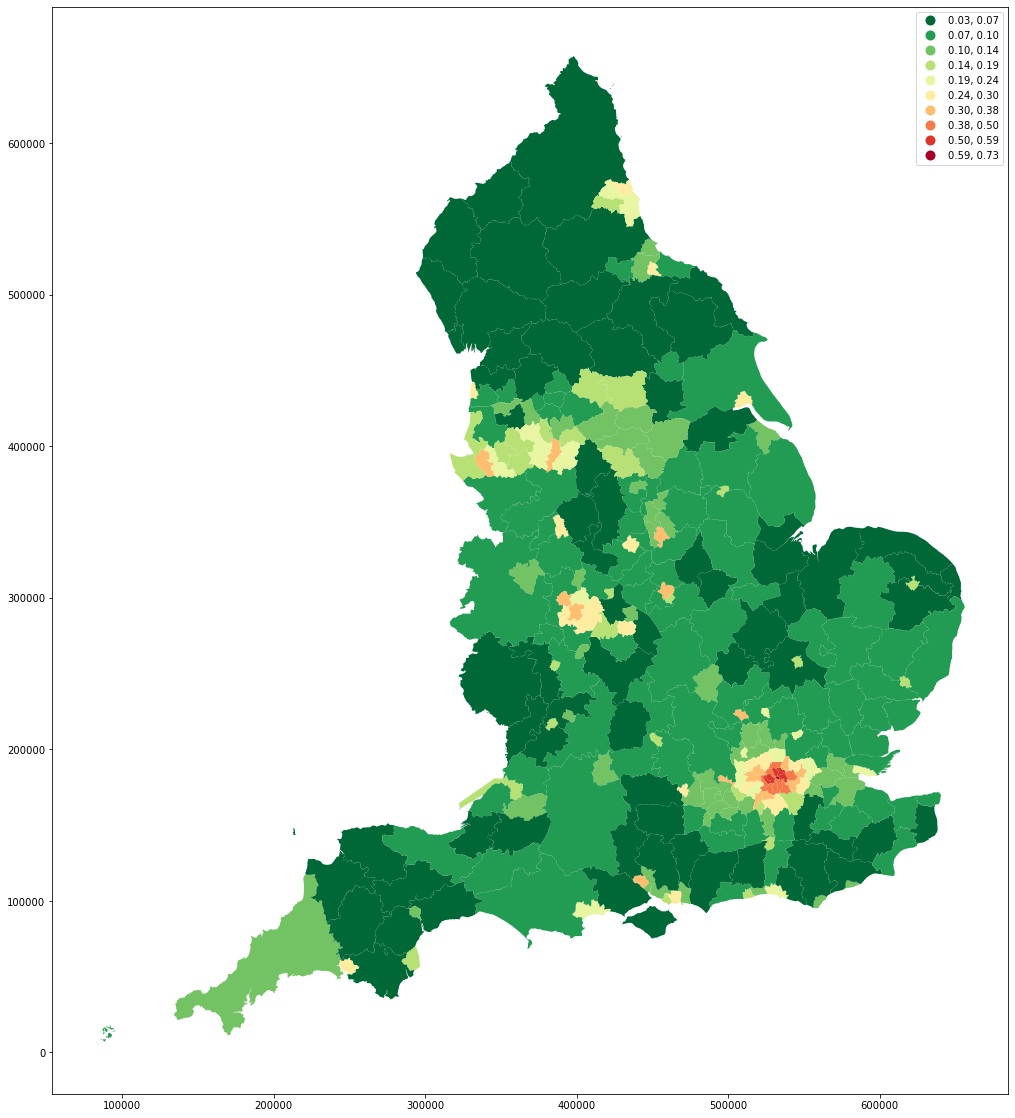

In [19]:
LAD.plot(column='Composite_Indicator', cmap='RdYlGn_r', 
         scheme='FisherJenks', k=10, edgecolor='None', legend=True, figsize=(20,20));
plt.savefig('./OUTPUT/Final_figure/CI_minmax_equal.png',dpi=250)

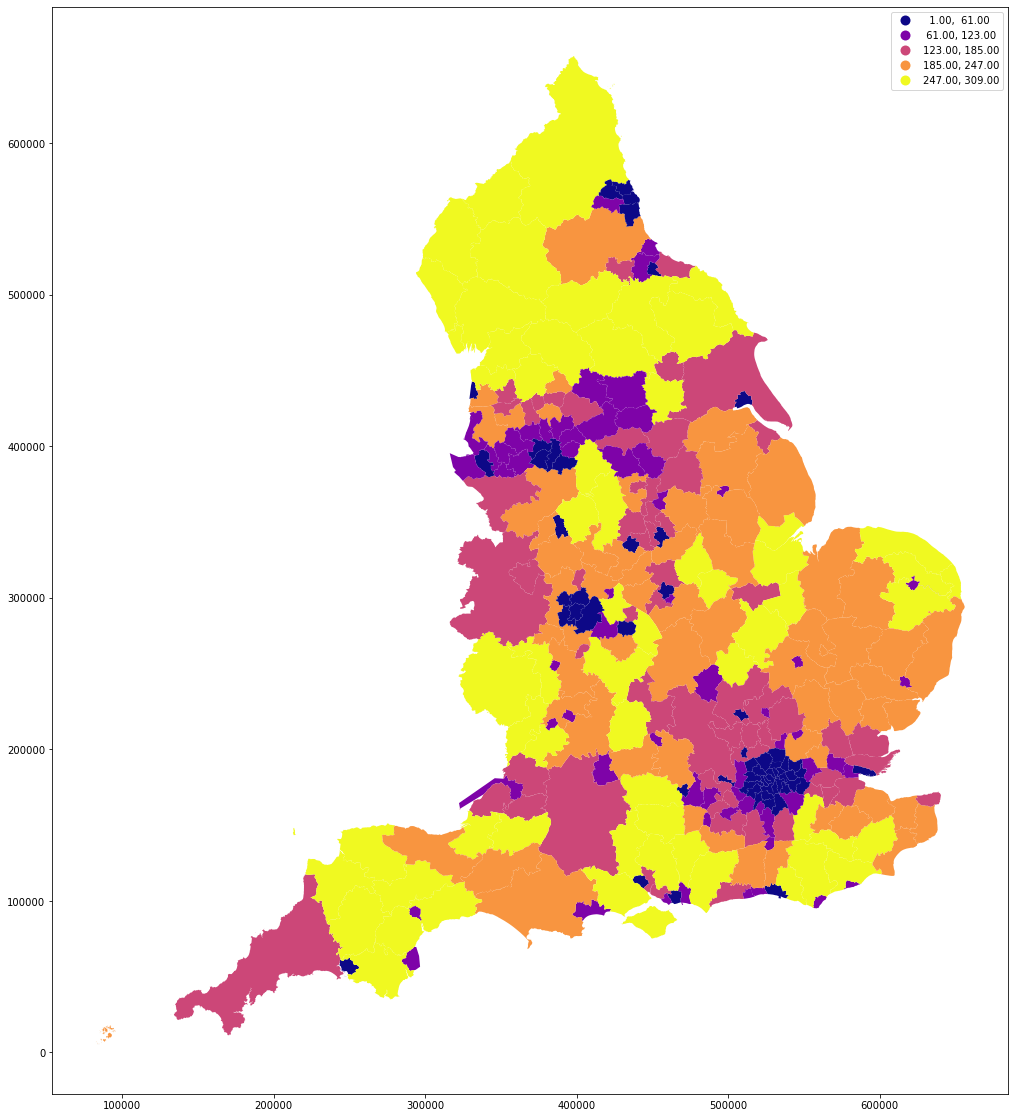

In [20]:
LAD.plot(column='Composite_Indicator_rank', cmap='plasma', 
         scheme='FisherJenks', k=5, edgecolor='None', legend=True, figsize=(20,20));

In [21]:
LAD = LAD.iloc[:309,:]

In [40]:
LAD_sort = LAD.sort_values(by =['Composite_Indicator_rank'], ascending=True, inplace = False)
head = LAD_sort.head(15)

In [41]:
head_output = head.loc[:][['LAD','LAD_Name','Region','Composite_Indicator','Composite_Indicator_rank',
                         'climate','landuse',
                         'pollution','overexplo', 'alien','air_pollution','water_pollution','noise_pollution','light_pollution']]

In [42]:
tail = LAD_sort.tail(15)

In [43]:
tail_output = tail.loc[:][['LAD','LAD_Name','Region','Composite_Indicator','Composite_Indicator_rank',
                         'climate','landuse',
                         'pollution','overexplo', 'alien','air_pollution','water_pollution','noise_pollution','light_pollution']]

In [44]:
head = head.loc[:][['LAD_Name','Composite_Indicator','Composite_Indicator_rank',
                         'climate','landuse',
                         'pollution','overexplo', 'alien']]

In [45]:
head

,LAD_Name,Composite_Indicator,Composite_Indicator_rank,climate,landuse,pollution,overexplo,alien
276,City of London,0.725953,1.0,1.000000,0.750106,0.691388,0.188270,1.000000
294,Islington,0.591543,2.0,0.220285,0.280662,0.624069,0.928713,0.903987
295,Kensington and Chelsea,0.583889,3.0,0.301674,0.288748,0.631376,0.753207,0.944438
305,Tower Hamlets,0.558919,4.0,0.269044,0.257991,0.528585,1.000000,0.738976
287,Hackney,0.530885,5.0,0.167059,0.253246,0.572378,0.866999,0.794741
308,Westminster,0.523649,6.0,0.360168,0.218624,0.573018,0.605272,0.861166
297,Lambeth,0.496554,7.0,0.168860,0.219488,0.566752,0.754483,0.773189
288,Hammersmith and Fulham,0.483460,8.0,0.187505,0.260321,0.547038,0.711086,0.711350
282,Camden,0.474722,9.0,0.226723,0.277816,0.544519,0.614015,0.710538
303,Southwark,0.469545,10.0,0.157254,0.234824,0.550776,0.678346,0.726524


In [46]:
tail = tail.loc[:][['LAD_Name','Composite_Indicator','Composite_Indicator_rank',
                         'climate','landuse',
                         'pollution','overexplo', 'alien']]

In [47]:
tail

,LAD_Name,Composite_Indicator,Composite_Indicator_rank,climate,landuse,pollution,overexplo,alien
175,Ryedale,0.057096,295.0,0.000861,0.128284,0.147762,0.000638,0.007933
83,Teignbridge,0.056981,296.0,0.004304,0.048212,0.163772,0.011105,0.057510
165,Broadland,0.056459,297.0,0.006138,0.055067,0.158843,0.013594,0.048653
177,Selby,0.055792,298.0,0.006442,0.071120,0.185296,0.008169,0.007933
16,Rutland,0.053185,299.0,0.012103,0.022657,0.201601,0.005169,0.024393
171,Craven,0.052610,300.0,0.001436,0.125873,0.126404,0.001404,0.007933
84,Torridge,0.051831,301.0,0.002098,0.053334,0.143469,0.002744,0.057510
85,West Devon,0.049352,302.0,0.001252,0.050314,0.136217,0.001468,0.057510
68,Eden,0.047467,303.0,0.002177,0.127535,0.100974,0.000000,0.006646
173,Harrogate,0.047149,304.0,0.003946,0.075209,0.142401,0.006254,0.007933
